In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from proj.data.load import load_ibkr_prices, load_macro_series
from proj.data.reshaping import *
from proj.utils.dates import duration_to_dates

In [6]:
import asyncio
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.diagnostic import het_arch

In [ ]:

plt.style.use("../styler.mplstyle") 

In [8]:
DURATION = "10 Y"        # hyperparameter
END_DATE = None 

START_DATE, END_DATE = duration_to_dates(DURATION, end=END_DATE)
START_DATE, END_DATE

(datetime.date(2015, 12, 4), datetime.date(2025, 12, 4))

## 1.1

In [9]:
portfolio = [
    #  S&P 500 
    'AMZN',
    'AAPL',
    'JPM',

    # Russel 2000
    'BE',
    'RKLB',

    # Nasdaq 100 
    'PLTR'
    ]

In [10]:
intra = await load_ibkr_prices(portfolio, duration='3 M', bar_size='15 mins')

Connected to Interactive Brokers successfully.


In [11]:
intra

,date,Symbol,open,high,low,close,volume
0,2025-09-08 09:30:00,AMZN,235.00,235.49,233.85,234.93,2714489.0
1,2025-09-08 09:45:00,AMZN,234.94,235.26,233.87,234.18,1090938.0
2,2025-09-08 10:00:00,AMZN,234.20,234.37,233.75,233.98,808354.0
3,2025-09-08 10:15:00,AMZN,233.98,235.37,233.87,235.36,771413.0
4,2025-09-08 10:30:00,AMZN,235.35,237.21,235.34,236.84,2222757.0
...,...,...,...,...,...,...,...
9715,2025-12-04 13:15:00,PLTR,177.26,177.48,176.76,176.90,334968.0
9716,2025-12-04 13:30:00,PLTR,176.86,177.14,176.48,176.56,400047.0
9717,2025-12-04 13:45:00,PLTR,176.58,177.03,176.33,176.99,468266.0
9718,2025-12-04 14:00:00,PLTR,176.97,177.25,176.71,176.83,471766.0


In [12]:
daily = await load_ibkr_prices(portfolio, duration= '10 Y')

Connected to Interactive Brokers successfully.


In [13]:
daily = daily.sort_values(['Symbol', 'date'])

In [14]:
pivoted = long_to_wide(daily)

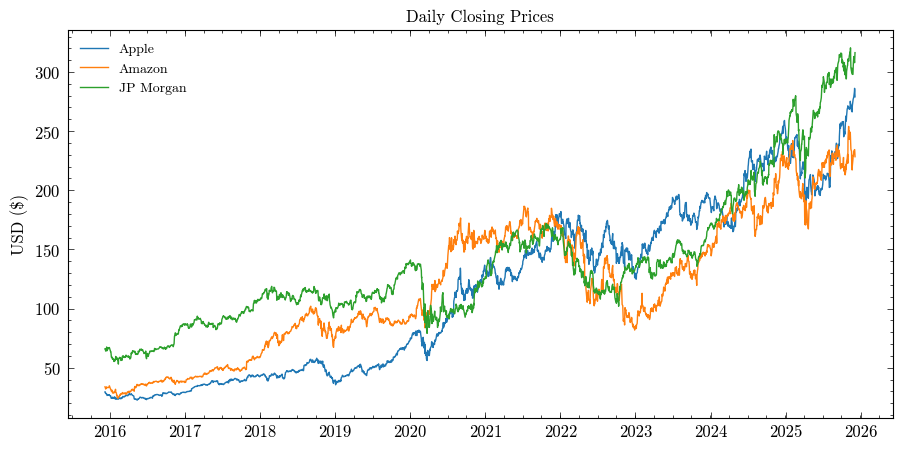

In [15]:
plt.figure(figsize=(10,5))
plt.title('Daily Closing Prices')
plt.plot(pivoted['date'], pivoted['AAPL'], label='Apple')
plt.plot(pivoted['date'], pivoted['AMZN'], label = 'Amazon')
plt.plot(pivoted['date'], pivoted['JPM'], label = 'JP Morgan')

plt.ylabel('USD ($)')
plt.legend()

plt.savefig(f'../Figures/Assignment09/daily.png', dpi = 300)
plt.show()

### 1.2


summary statistics

In [16]:
daily = daily.set_index('date')

In [17]:
daily

,Symbol,open,high,low,close,volume
date,,,,,,
2015-12-08,AAPL,29.36,29.65,29.22,29.56,115394960.0
2015-12-09,AAPL,29.41,29.42,28.77,28.91,146376420.0
2015-12-10,AAPL,29.01,29.24,28.88,29.04,99358104.0
2015-12-11,AAPL,28.80,28.85,28.21,28.30,154481644.0
2015-12-14,AAPL,28.05,28.17,27.45,28.12,222162176.0
...,...,...,...,...,...,...
2025-11-28,RKLB,42.51,42.70,41.80,42.14,3916342.0
2025-12-01,RKLB,41.15,41.30,39.99,40.37,8581508.0
2025-12-02,RKLB,40.56,42.99,40.42,41.90,9044569.0


In [18]:

daily['returns'] = daily.groupby('Symbol')['close'].transform(
    lambda x: x.pct_change()
)


In [19]:
summary = daily.groupby('Symbol')['returns'].agg(
    avg_log_return='mean',
    volatility='std',
    min_return='min',
    max_return='max',
    n_obs='count'
)

print(summary)

        avg_log_return  volatility  min_return  max_return  n_obs
Symbol                                                           
AAPL          0.001062    0.018352   -0.128652    0.153288   2512
AMZN          0.000974    0.020725   -0.140526    0.135326   2512
BE            0.002532    0.059156   -0.425000    0.591867   1851
JPM           0.000775    0.017410   -0.149649    0.180125   2512
PLTR          0.003225    0.044817   -0.213080    0.308014   1301
RKLB          0.002400    0.048206   -0.204167    0.373095   1267


## 1.3 


### Trading Logic

In [20]:
short_window = 20
long_window  = 50

daily['ma_short'] = (
    daily.groupby('Symbol')['close']
      .transform(lambda x: x.rolling(short_window, min_periods=short_window).mean())
)

daily['ma_long'] = (
    daily.groupby('Symbol')['close']
      .transform(lambda x: x.rolling(long_window, min_periods=long_window).mean())
)



In [21]:
daily['signal'] = 0
daily.loc[daily['ma_short'] > daily['ma_long'], 'signal'] = 1 # long
daily.loc[daily['ma_short'] < daily['ma_long'], 'signal'] = -1 # short

daily['signal_lagged'] = daily.groupby('Symbol')['signal'].shift(1)


In [22]:
daily

,Symbol,open,high,low,close,volume,returns,ma_short,ma_long,signal,signal_lagged
date,,,,,,,,,,,
2015-12-08,AAPL,29.36,29.65,29.22,29.56,115394960.0,NaN,NaN,NaN,0,NaN
2015-12-09,AAPL,29.41,29.42,28.77,28.91,146376420.0,-0.021989,NaN,NaN,0,0.0
2015-12-10,AAPL,29.01,29.24,28.88,29.04,99358104.0,0.004497,NaN,NaN,0,0.0
2015-12-11,AAPL,28.80,28.85,28.21,28.30,154481644.0,-0.025482,NaN,NaN,0,0.0
2015-12-14,AAPL,28.05,28.17,27.45,28.12,222162176.0,-0.006360,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-28,RKLB,42.51,42.70,41.80,42.14,3916342.0,0.005008,48.0535,54.6912,-1,-1.0
2025-12-01,RKLB,41.15,41.30,39.99,40.37,8581508.0,-0.042003,46.9230,54.5428,-1,-1.0
2025-12-02,RKLB,40.56,42.99,40.42,41.90,9044569.0,0.037899,45.9510,54.3846,-1,-1.0


dataframes with each unique stock

In [23]:
prices = daily.pivot(columns='Symbol', values='close')
returns = daily.pivot(columns='Symbol', values='returns')
signals  = daily.pivot(columns="Symbol", values="signal_lagged").fillna(0)


In [24]:
dollar_per_trade = 10_000
shares = (dollar_per_trade * signals) / prices
portfolio = shares.fillna(0)

In [25]:
portfolio

Symbol,AAPL,AMZN,BE,JPM,PLTR,RKLB
date,,,,,,
2015-12-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2025-11-28,35.861574,42.877969,91.541560,31.940718,-59.364797,-237.304224
2025-12-01,35.323207,42.756969,101.081573,32.370840,-59.705057,-247.708695
2025-12-02,34.941822,42.658476,95.238095,32.480187,-58.585740,-238.663484


### performance

In [26]:
pnl = portfolio.shift(1) * returns
total_pnl = pnl.sum(axis=1)
total_pnl

date
2015-12-08     0.000000
2015-12-09     0.000000
2015-12-10     0.000000
2015-12-11     0.000000
2015-12-14     0.000000
                ...    
2025-11-28     7.265385
2025-12-01     1.909649
2025-12-02    -3.951417
2025-12-03   -20.352309
2025-12-04    -6.494460
Length: 2513, dtype: float64

In [27]:
starting_capital = 1_000_000
portfolio_value = starting_capital + total_pnl.cumsum()
portfolio_ret = total_pnl / portfolio_value.shift(1)
equity = (1 + portfolio_ret.fillna(0)).cumprod() * starting_capital

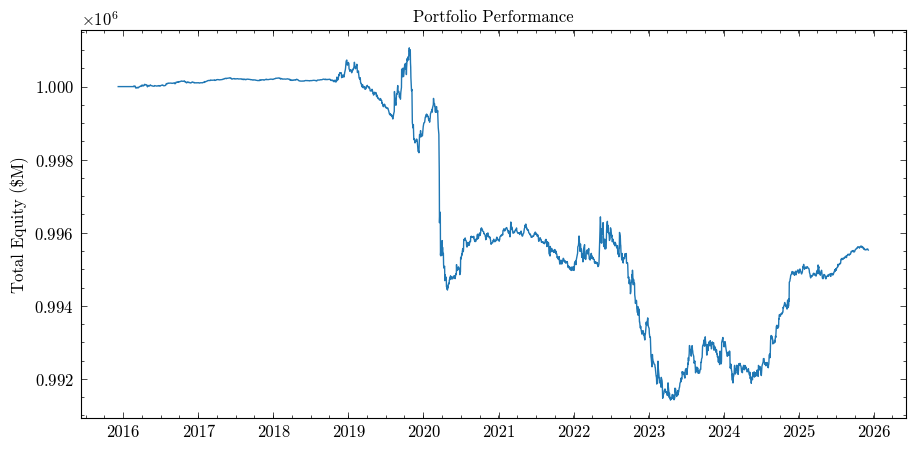

In [28]:
plt.figure(figsize=(10,5))
plt.title('Portfolio Performance')
plt.plot(equity)
plt.ylabel('Total Equity ($M)')
plt.savefig(f'../Figures/Assignment09/pnl.png', dpi = 300)

In [29]:
window = 21

In [30]:
daily_vol = portfolio_ret.rolling(window).std()
ann_vol = daily_vol * np.sqrt(252)

rolling_mean = portfolio_ret.rolling(window).mean()
rolling_std  = portfolio_ret.rolling(window).std()

rolling_sharpe_daily = rolling_mean / rolling_std
rolling_sharpe_ann   = rolling_sharpe_daily * np.sqrt(252)

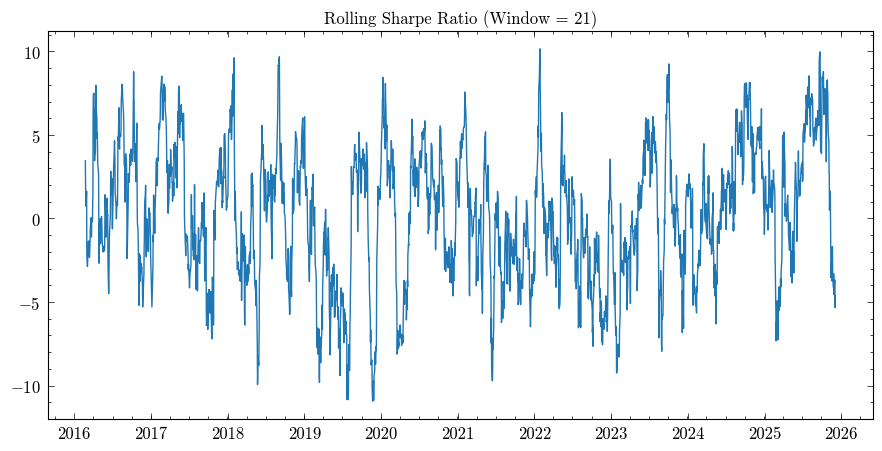

In [31]:
plt.figure(figsize=(10,5))
plt.title(f'Rolling Sharpe Ratio (Window = {window})')
plt.plot(rolling_sharpe_ann)
plt.savefig(f'../Figures/Assignment09/sharpe.png', dpi = 300)

In [32]:
rolling_var_95 = portfolio_ret.rolling(window).quantile(0.05)
rolling_var_99 = portfolio_ret.rolling(window).quantile(0.01)

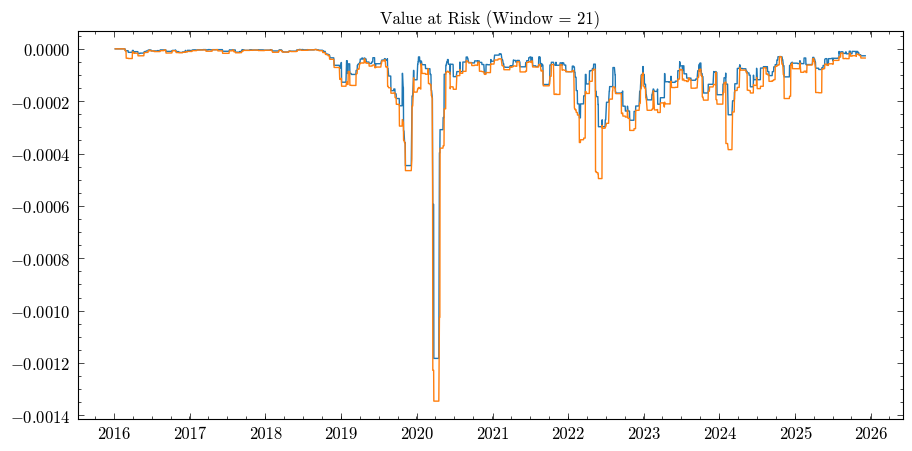

In [33]:
plt.figure(figsize=(10,5))
plt.title(f'Value at Risk (Window = {window})')
plt.plot(rolling_var_95, label = '95%')
plt.plot(rolling_var_99, label = '99 %')

plt.savefig(f'../Figures/Assignment09/var.png', dpi = 300)

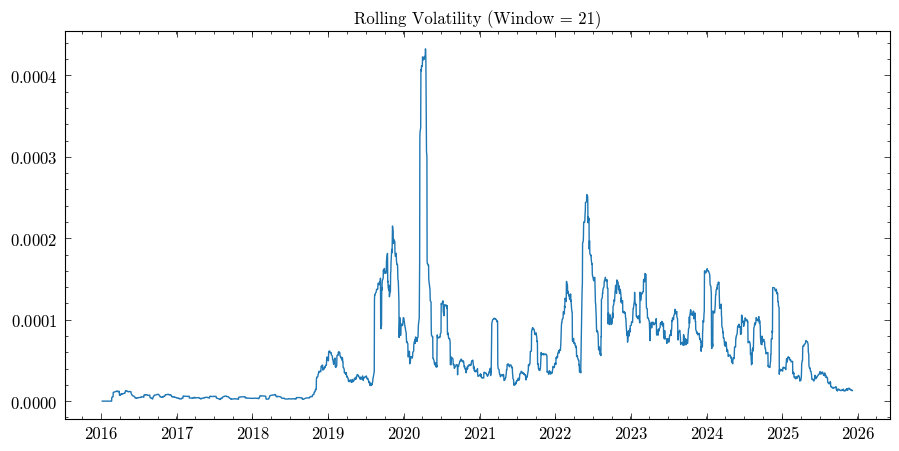

In [34]:
plt.figure(figsize=(10,5))
plt.title(f'Rolling Volatility (Window = {window})')
plt.plot(daily_vol)
plt.savefig(f'../Figures/Assignment09/daily_vol.png', dpi = 300)

In [39]:
def print_daily_results(portfolio_ret):
    """
    Pretty-print daily performance metrics.
    Expects a Pandas Series of daily returns (fractional).
    """

    portfolio_ret = portfolio_ret.dropna()
    last_ret = portfolio_ret.iloc[-1]
    today = portfolio_ret.index[-1]

    # cumulative return
    cum_ret = (1 + portfolio_ret).prod() - 1

    # volatility
    daily_vol = portfolio_ret.std()
    ann_vol = daily_vol * (252 ** 0.5)

    # sharpe
    sharpe = (portfolio_ret.mean() / daily_vol) * (252 ** 0.5) if daily_vol != 0 else 0.0

    # VaR
    var_95 = portfolio_ret.quantile(0.05)
    var_99 = portfolio_ret.quantile(0.01)

    print("────────────────────────────────────────────")
    print(f"Date:                 {today.date()}")
    print("────────────────────────────────────────────")
    print(f"Daily Return:         {last_ret*100:8.4f}%")
    print(f"Cumulative Return:    {cum_ret*100:8.4f}%")
    print(f"Daily Volatility:     {daily_vol*100:8.4f}%")
    print(f"Annual Volatility:    {ann_vol*100:8.4f}%")
    print(f"Sharpe Ratio:          {sharpe:8.4f}")
    print(f" VaR (95%):             {var_95*100:8.4f}%")
    print(f" VaR (99%):             {var_99*100:8.4f}%")
    print("────────────────────────────────────────────")

In [40]:
print_daily_results(portfolio_ret)

────────────────────────────────────────────
Date:                 2025-12-04
────────────────────────────────────────────
Daily Return:          -0.0007%
Cumulative Return:     -0.4474%
Daily Volatility:       0.0085%
Annual Volatility:      0.1342%
Sharpe Ratio:           -0.3344
 VaR (95%):              -0.0107%
 VaR (99%):              -0.0250%
────────────────────────────────────────────
